In [1]:
import simpy, random
from queue_simulation2 import ServiceOperation, SIMULATION_DURATION, SEED

In [2]:
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Initializing OpenUp Queue Simulation')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

random.seed(SEED) # comment out line if not reproducing results
queue_status = []
max_queue_length = []
num_helpseekers = []
num_helpseekers_served = []
num_helpseekers_served_g_regular = []
num_helpseekers_served_g_repeated = []
num_helpseekers_reneged = []
# num_helpseekers_reneged_g_regular = []
# num_helpseekers_reneged_g_repeated = []
num_available_counsellor_processes = []
queue_time_stats = []
renege_time_stats = []
    
for i in range(1, 1501):
    # create environment
    env = simpy.Environment() 

    # set up service operation and run simulation until  
    S = ServiceOperation(env=env)
    env.run(until=SIMULATION_DURATION)

#     print(f'Iteration #{i} ')
      
    num_helpseekers.append(S.num_helpseekers)
    max_queue_length.append(S.helpseeker_queue_max_length)
    queue_status.extend(S.queue_status)
    num_available_counsellor_processes.extend(S.num_available_counsellor_processes)
    num_helpseekers_served.append(S.served)
    num_helpseekers_served_g_regular.append(S.served_g_regular)
    num_helpseekers_served_g_repeated.append(S.served_g_repeated)
    num_helpseekers_reneged.append(S.reneged)
    queue_time_stats.append(S.queue_time_stats)
    renege_time_stats.append(S.renege_time_stats)
#     num_helpseekers_reneged_g_regular.append(S.reneged_g_regular)
#     num_helpseekers_reneged_g_repeated.append(S.reneged_g_repeated)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initializing OpenUp Queue Simulation
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
sns.set();

In [5]:
num_helpseekers = pd.Series(num_helpseekers, name='number of helpseekers')
num_helpseekers_served = pd.Series(num_helpseekers_served, name='number of helpseekers served')
num_helpseekers_served_g_regular = pd.Series(num_helpseekers_served_g_regular, name='number of users served')
num_helpseekers_served_g_repeated = pd.Series(num_helpseekers_served_g_repeated, name='number of repeated users served')
num_helpseekers_reneged = pd.Series(num_helpseekers_reneged, name='number of helpseekers reneged')
# num_helpseekers_reneged_g_regular = pd.Series(num_helpseekers_reneged_g_regular, name='number of users reneged')
# num_helpseekers_reneged_g_repeated = pd.Series(num_helpseekers_reneged_g_repeated, name='number of repeated users reneged')
# queue_status = pd.Series(queue_status, name='number of instances queue exceeded four helpseekers')
max_queue_length = pd.Series(max_queue_length, name='max queue length')

In [6]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

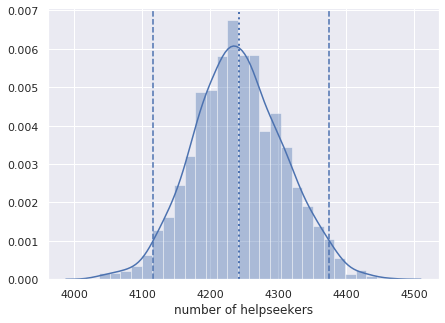

In [9]:
plot_distribution(num_helpseekers, 'num_helpseekers')

In [10]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4115.47500
97.5% percentile: 4374.05000

mean value: 4241.49000


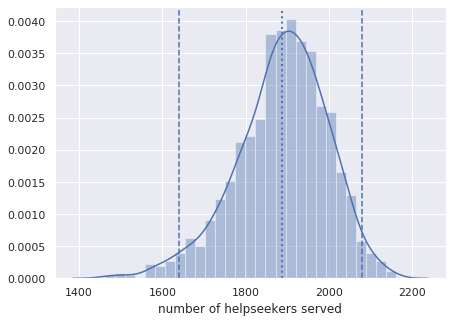

In [11]:
plot_distribution(num_helpseekers_served, 'num_helpseekers_served')

In [12]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 1640.47500
97.5% percentile: 2080.57500

mean value: 1888.20067


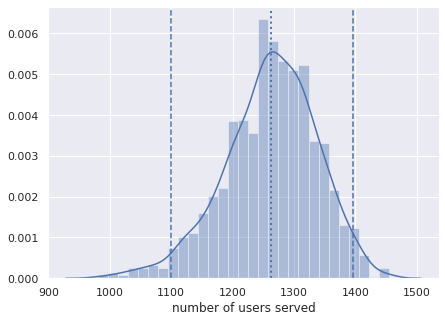

In [13]:
plot_distribution(num_helpseekers_served_g_regular, 'num_helpseekers_served_g_regular')

In [14]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 1099.95000
97.5% percentile: 1395.52500

mean value: 1262.05400


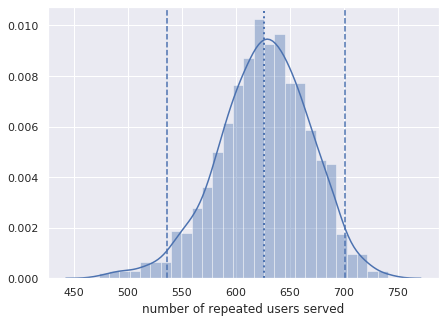

In [15]:
plot_distribution(num_helpseekers_served_g_repeated, 'num_helpseekers_served_g_repeated')

In [16]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 536.42500
97.5% percentile: 701.00000

mean value: 626.14667


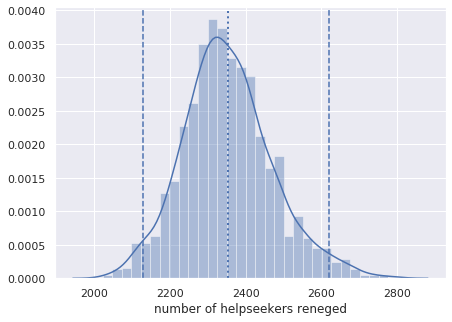

In [17]:
plot_distribution(num_helpseekers_reneged, 'num_helpseekers_reneged')

In [18]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2128.47500
97.5% percentile: 2619.52500

mean value: 2352.66200


In [19]:
# plot_distribution(num_helpseekers_reneged_g_regular, 'num_helpseekers_reneged_g_regular')

In [20]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_helpseekers_reneged_g_regular.sort_values().to_list() )

In [21]:
# plot_distribution(num_helpseekers_reneged_g_repeated, 'num_helpseekers_reneged_g_repeated')

In [22]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_helpseekers_reneged_g_repeated.sort_values().to_list() )

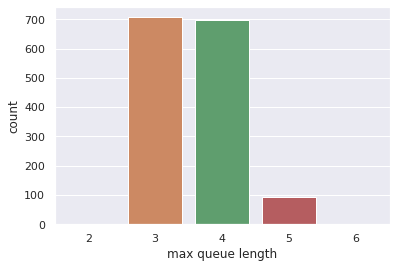

In [23]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [24]:
queue_status = pd.DataFrame(queue_status, columns=['day_of_week', 'hour', 'queue_length'])

In [25]:
queue_status['hour'] = queue_status['hour'].str.replace('hour:', '').astype(int)

In [26]:
queue_status['day_of_week'].replace({
    'weekday:0': 'Sunday',
    'weekday:1': 'Monday',
    'weekday:2': 'Tuesday',
    'weekday:3': 'Wednesday',
    'weekday:4': 'Thursday',
    'weekday:5': 'Friday',
    'weekday:6': 'Saturday'
}, inplace=True)

In [27]:
queue_status['queue_length'] = queue_status['queue_length'].str.replace('queue_length:', '').astype(int)

In [28]:
queue_status

,day_of_week,hour,queue_length
0,Sunday,0,0
1,Sunday,0,0
2,Sunday,0,0
3,Sunday,0,0
4,Sunday,0,0
...,...,...,...
6361584,Monday,23,0
6361585,Monday,23,0
6361586,Monday,23,0
6361587,Monday,23,0


In [29]:
queue_status['total']=1

In [30]:
totals = queue_status.groupby(
    ['day_of_week', 'hour', 'queue_length']).sum()

In [31]:
totals = totals.reset_index()

In [32]:
totals

,day_of_week,hour,queue_length,total
0,Friday,0,0,66261
1,Friday,0,1,3593
2,Friday,0,2,734
3,Friday,0,3,87
4,Friday,0,4,11
...,...,...,...,...
776,Wednesday,23,1,14059
777,Wednesday,23,2,2556
778,Wednesday,23,3,319
779,Wednesday,23,4,26


In [33]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['day_of_week', 'hour'], aggfunc=np.sum, fill_value=0)

In [34]:
totals_percent = (((totals.T/totals.T.sum()).T)*100)#.round(2)

totals_percent

In [35]:
totals_percent

queue_length              0          1         2         3         4  \
day_of_week hour                                                       
Friday      0     93.737268   5.082900  1.038366  0.123076  0.015561   
            1     88.545862   9.765180  1.519872  0.161486  0.005700   
            2     92.301580   6.719942  0.899019  0.077189  0.002270   
            3     97.385153   2.447942  0.158957  0.007948  0.000000   
            4     99.134707   0.842963  0.022330  0.000000  0.000000   
...                     ...        ...       ...       ...       ...   
Wednesday   19    84.929779  13.340772  1.598467  0.128557  0.002426   
            20    87.003244  11.427920  1.464923  0.093775  0.010138   
            21    77.166255  19.345256  3.155296  0.301078  0.032115   
            22    74.470550  21.980474  3.205665  0.315417  0.023603   
            23    69.457498  25.313743  4.602171  0.574371  0.046814   

queue_length             5    6  
day_of_week hour                 
Friday      0     0.002829  0.0  
            1     0.001900  0.0  
            2     0.000000  0.0  
            3     0.000000  0.0  
            4     0.000000  0.0  
...                    ...  ...  
Wednesday   19    0.000000  0.0  
            20    0.000000  0.0  
            21    0.000000  0.0  
            22    0.004291  0.0  
            23    0.005402  0.0  

[168 rows x 7 columns]

In [36]:
totals_percent2 = totals_percent.reset_index()

In [37]:
totals_percent2['day_int'] = totals_percent2['day_of_week'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [38]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['day_of_week', 'hour']).drop(columns=['day_int'])

In [39]:
totals_percent2

queue_length              0          1         2         3         4  \
day_of_week hour                                                       
Sunday      0     92.998306   5.617165  1.202710  0.162620  0.016940   
            1     88.861828   9.636305  1.352492  0.136386  0.011365   
            2     91.275363   7.547299  1.084796  0.089114  0.003427   
            3     95.052252   4.450661  0.450846  0.046241  0.000000   
            4     96.631285   3.129033  0.231780  0.007902  0.000000   
...                     ...        ...       ...       ...       ...   
Saturday    19    78.925375  18.015990  2.759068  0.276670  0.022897   
            20    74.266208  20.795405  4.277355  0.588272  0.069664   
            21    78.838228  18.255184  2.632544  0.243834  0.025894   
            22    71.017586  24.331778  4.157615  0.445796  0.041557   
            23    70.360764  24.732852  4.382135  0.487716  0.036533   

queue_length             5    6  
day_of_week hour                 
Sunday      0     0.002259  0.0  
            1     0.001624  0.0  
            2     0.000000  0.0  
            3     0.000000  0.0  
            4     0.000000  0.0  
...                    ...  ...  
Saturday    19    0.000000  0.0  
            20    0.003096  0.0  
            21    0.004316  0.0  
            22    0.005667  0.0  
            23    0.000000  0.0  

[168 rows x 7 columns]

In [40]:
totals_percent2['2_or_above'] = 0
for i in totals_percent2.columns[2:]:
    totals_percent2['2_or_above'] += totals_percent2[i]

In [41]:
totals_percent2.reset_index(inplace=True)

In [42]:
totals_percent2['new_ind'] = totals_percent2['day_of_week'] + '_'+ totals_percent2['hour'].astype(str)

In [43]:
totals_percent3 = totals_percent2.set_index('new_ind')[[0, 1, '2_or_above']].copy()

In [44]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('talk')

In [45]:
# fig, ax = plt.subplots(figsize=(10, 100) )


# sns.heatmap(totals_percent, annot=True, ax=ax, annot_kws={"size": 12}, 
#     cmap=sns.diverging_palette(220, 10, sep=80, n=255)
# );
# fig.suptitle('Queue Length Probabilities by\nthe day of the week and hour\n'
#              '#Social Worker(s) × #sim chats max: 2 × 4,\n'
#              '#Duty Officer(s) × #sim chats max: 1 × 1,\n'
#              '#Volunteer(s) × #sim chats max: 2 × 1',
#     fontsize=24, weight='heavy',
#     fontweight=1000, y=.9)
# plt.subplots_adjust(bottom=0.2)

# # workaround from https://github.com/mwaskom/seaborn/issues/1773
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')

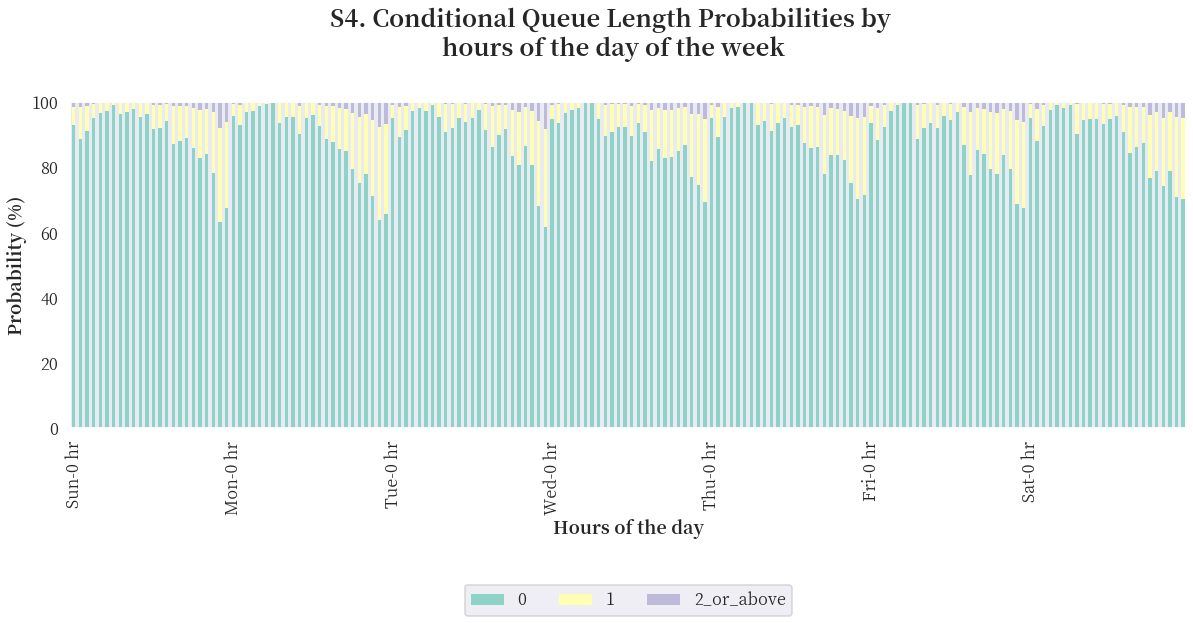

In [46]:
fig, ax = plt.subplots(figsize=(20,6) )
palette = sns.color_palette("Set3")

fig.suptitle('S4. Conditional Queue Length Probabilities by\n hours of the day of the week',
    fontsize=24, weight='heavy',
    fontweight=1000, y=1.1)

totals_percent3.plot.bar(
    stacked=True,
    ax=ax,
    linewidth=.01,
    color=palette
)
ax.set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
    if x[-2:] == '_0' else ''
    for x in totals_percent3.index])

ax.set_xlabel('Hours of the day')
ax.set_ylabel('Probability (%)')



ax.set_ylim(0,100)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.6), ncol=3)
fig.savefig(f'queue_output/Queue_SW_21_DO_11_V_31.png', dpi=300, bbox_inches='tight')

In [ ]:
# queue_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [47]:
queue_time_stats[0]

[('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:0', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:1', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:1', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:1', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:1', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:1', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:1', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:2', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:2', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:2', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:2', 'time_spent_in_queue:0.0'),
 ('weekday:0', 'hour:3', 'time_spent_in_queue:

In [48]:
queue_time_stats = pd.DataFrame(queue_time_stats[0], columns=['day_of_week', 'hour', 'queue_time'])

In [49]:
queue_time_stats['hour'] = queue_time_stats['hour'].str.replace('hour:', '').astype(int)

In [50]:
queue_time_stats['day_of_week'].replace({
    'weekday:0': 'Sunday',
    'weekday:1': 'Monday',
    'weekday:2': 'Tuesday',
    'weekday:3': 'Wednesday',
    'weekday:4': 'Thursday',
    'weekday:5': 'Friday',
    'weekday:6': 'Saturday'
}, inplace=True)

In [51]:
queue_time_stats

,day_of_week,hour,queue_time
0,Sunday,0,time_spent_in_queue:0.0
1,Sunday,0,time_spent_in_queue:0.0
2,Sunday,0,time_spent_in_queue:0.0
3,Sunday,0,time_spent_in_queue:0.0
4,Sunday,0,time_spent_in_queue:0.0
...,...,...,...
1774,Monday,16,time_spent_in_queue:1.0689263892490999
1775,Monday,16,time_spent_in_queue:0.0
1776,Monday,16,time_spent_in_queue:3.311897692299681
1777,Monday,17,time_spent_in_queue:0.0


In [52]:
queue_time_stats['queue_time'] = queue_time_stats['queue_time'].str.replace(
    'time_spent_in_queue:', '').astype(float)

In [53]:
queue_time_stats

,day_of_week,hour,queue_time
0,Sunday,0,0.000000
1,Sunday,0,0.000000
2,Sunday,0,0.000000
3,Sunday,0,0.000000
4,Sunday,0,0.000000
...,...,...,...
1774,Monday,16,1.068926
1775,Monday,16,0.000000
1776,Monday,16,3.311898
1777,Monday,17,0.000000


In [54]:
queue_time_stats['total']=1

In [60]:
# totals = 
queue_time_stats.mean()

hour          7.373806
queue_time    0.144256
total         1.000000
dtype: float64

In [ ]:
totals = totals.reset_index()

In [ ]:
totals

In [ ]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['day_of_week', 'hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
totals_percent = (((totals.T/totals.T.sum()).T)*100)#.round(2)

totals_percent

In [ ]:
totals_percent

In [ ]:
totals_percent2 = totals_percent.reset_index()

In [ ]:
totals_percent2['day_int'] = totals_percent2['day_of_week'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [ ]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['day_of_week', 'hour']).drop(columns=['day_int'])

In [ ]:
totals_percent2

In [ ]:
totals_percent2['2_or_above'] = 0
for i in totals_percent2.columns[2:]:
    totals_percent2['2_or_above'] += totals_percent2[i]

In [ ]:
totals_percent2.reset_index(inplace=True)

In [ ]:
totals_percent2['new_ind'] = totals_percent2['day_of_week'] + '_'+ totals_percent2['hour'].astype(str)

In [ ]:
totals_percent3 = totals_percent2.set_index('new_ind')[[0, 1, '2_or_above']].copy()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('talk')

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 100) )


# sns.heatmap(totals_percent, annot=True, ax=ax, annot_kws={"size": 12}, 
#     cmap=sns.diverging_palette(220, 10, sep=80, n=255)
# );
# fig.suptitle('Queue Length Probabilities by\nthe day of the week and hour\n'
#              '#Social Worker(s) × #sim chats max: 2 × 4,\n'
#              '#Duty Officer(s) × #sim chats max: 1 × 1,\n'
#              '#Volunteer(s) × #sim chats max: 2 × 1',
#     fontsize=24, weight='heavy',
#     fontweight=1000, y=.9)
# plt.subplots_adjust(bottom=0.2)

# # workaround from https://github.com/mwaskom/seaborn/issues/1773
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6) )
palette = sns.color_palette("Set3")

fig.suptitle('S2. Conditional Queue Length Probabilities by\n hours of the day of the week',
    fontsize=24, weight='heavy',
    fontweight=1000, y=1.1)

totals_percent3.plot.bar(
    stacked=True,
    ax=ax,
    linewidth=.01,
    color=palette
)
ax.set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
    if x[-2:] == '_0' else ''
    for x in totals_percent3.index])

ax.set_xlabel('Hours of the day')
ax.set_ylabel('Probability (%)')



ax.set_ylim(0,100)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.6), ncol=3)
fig.savefig(f'queue_output/Queue_SW_21_DO_11_V_21.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [ ]:
df2 = pd.DataFrame(num_available_counsellor_processes, columns=['time', 'num_counsellor_processes'])

In [ ]:
from queue_simulation import MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR#, MAX_NUM_SIMULTANEOUS_CHATS

In [ ]:
df2['time_int'] = df2['time'].astype(int)

In [ ]:
df2['current_day_minutes'] = df2['time_int'] % MINUTES_PER_DAY

In [ ]:
df2['weekday'] = (df2['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [ ]:
df2['hour'] = (df2['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [ ]:
df2['day_of_week'] = df2['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

# Number of instances when one/no counsellor is available (1500 simulations, seed=728, four or less processes)

In [ ]:
process_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=df2[df2['num_counsellor_processes']<=2], kind="count",
    height=4, aspect=1);
process_plot.savefig(f'process_plot.png', dpi=300, bbox_inches='tight')

# Number of instances when at least two counsellors are idle (1500 simulations, seed=728, eight or more processes)

In [ ]:
process_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=df2[df2['num_counsellor_processes']>=8], kind="count",
    height=4, aspect=1);
process_plot.savefig(f'process_plot_2.png', dpi=300, bbox_inches='tight')